ウィルス分布のデータを作成する。

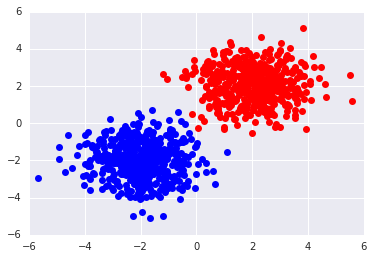

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_positive = np.random.randn(500, 1) + 2
y_positive = np.random.randn(500, 1) + 2
x_negative = np.random.randn(500, 1) - 2
y_negative = np.random.randn(500, 1) - 2

plt.figure(1)
plt.plot(x_positive, y_positive, 'ro', label='Data1')
plt.plot(x_negative, y_negative, 'bo', label='Data2')

感染、非感染の(x,y)座標を1つのデータに結合する

In [2]:
N = len(x_positive)
POSITIVE = np.zeros((N,2))
for i in xrange(N):
  POSITIVE[i][0] = x_positive[i]
  POSITIVE[i][1] = y_positive[i]

NEGATIVE = np.zeros((N,2))
for i in xrange(N):
  NEGATIVE[i][0] = x_negative[i]
  NEGATIVE[i][1] = y_negative[i]

VIRUS = np.vstack([NEGATIVE, POSITIVE]).astype(np.float32)

print VIRUS

[[-1.79510105 -0.9344911 ]
 [-1.83358312 -2.57615113]
 [-2.8175962  -1.28735662]
 ..., 
 [ 3.75633049  2.54164767]
 [ 1.97954583  1.36675024]
 [ 2.33600497  1.39233327]]


各データにラベル付けをする。ウイルス感染のラベルを[0,1]、ウイルス非感染のラベルを[1,0]にする

In [49]:
STATE = np.zeros((N*2,2), dtype=np.float32)
for i in xrange(N*2):
  if i < N:
    STATE[i][1] = 1
  else:
    STATE[i][0] = 1

print STATE

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


それでは、ここからTensorFlowで結果を求める。

In [50]:
tf.reset_default_graph()
LOGDIR = "./data"
 
x = tf.placeholder(tf.float32, shape=(None,2), name="input")
y = tf.placeholder(tf.float32, shape=(None,2), name="output")
w = tf.Variable(tf.random_normal([2,2], stddev=0.01), dtype=tf.float32, name="weight")
b = tf.Variable(tf.random_normal([2], stddev=0.01), dtype=tf.float32, name="bias")

ロジスティック回帰のモデルを定義する

In [51]:
with tf.name_scope('forward'):
  y_pred = tf.nn.softmax(tf.matmul(x,w) + b, name="forward")

コストの計算する

In [52]:
with tf.name_scope('cost'):
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred)
  cost = tf.reduce_mean(loss, 0)

予測する

In [53]:
with tf.name_scope('predict'):
  predict_op = tf.argmax(y_pred, 1)

精度の計算をする

In [54]:
with tf.name_scope('accuracy'):
  correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(STATE,1))
  accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

トレーニングの設定をする

In [55]:
with tf.Session() as sess:
  # 初期化処理
  init_op = tf.global_variables_initializer()
  sess.run(init_op)

  # トレーニング
  learning_rate = 0.01
  train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

  # Summary
  summary_writer = tf.summary.FileWriter(LOGDIR, sess.graph)

  with tf.Graph().as_default():
    # トレーニング回数
    training_step = 1000
    validation_step = 100

    # トレーニング
    for step in xrange(training_step):
      sess.run(train_op, feed_dict={x: VIRUS, y: STATE})

      if step % validation_step == 0:
        accuracy_output,cost_output = sess.run([accuracy_op,cost], feed_dict={x: VIRUS, y: STATE})
        print "step %d, cost %f, accuracy %f" % (step,cost_output,accuracy_output)

    summary_writer.flush()

    # Check answer
    data = [[-2,-2]]
    x_check = np.array(data)
    ans = sess.run(predict_op, feed_dict={x: x_check, y: STATE})
    print "[-2,-2]'s answer %d" % (ans)

    data = [[2,2]]
    x_check = np.array(data)
    ans = sess.run(predict_op, feed_dict={x: x_check, y: STATE})
    print "[2,2]'s answer %d" % (ans)

step 0, cost 0.698565, accuracy 0.014000
step 100, cost 0.397773, accuracy 0.999000
step 200, cost 0.363852, accuracy 0.999000
step 300, cost 0.350910, accuracy 0.999000
step 400, cost 0.343933, accuracy 0.999000
step 500, cost 0.339509, accuracy 0.999000
step 600, cost 0.336426, accuracy 0.999000
step 700, cost 0.334139, accuracy 0.999000
step 800, cost 0.332366, accuracy 0.999000
step 900, cost 0.330947, accuracy 0.999000
[-2,-2]'s answer 1
[2,2]'s answer 0
